<h1><strong><center>Discussion About Ethical Hacking Graph Issues, BO1 Traffic Burst</center></strong></h1>

Note: I thought I'd leave this post alone once the criminal investigation concluded, since I expected Bolivian prosecutors to clear up the confusion around what happened, but they never did. After a year and a half of investigation, in July 2021 they dismissed the case based on the conclusions of a <a href="https://drive.google.com/file/d/1MP4WZmDejLAmygNIsouyPjjttVDCk2vh/view?usp=sharing">new audit</a> of the IT system from the University of Salamanca's BISITE Research Group, and that was that. Weeks earlier, in anticipation of that audit, I published a Twitter <a href="https://twitter.com/distantcomment/status/1411209070720212993">thread</a> with my own explanation of the bo1 traffic increase, which turned out to be consistent with the BISITE audit. However, that section of their audit was so vague that, in the end, my explanation is the only one that describes the fundamental causes of the traffic increase. It occurs to me, now in March 2022, that this is likely to remain the case for a very long time, maybe forever, so I thought I'd clean up this post a bit and present a final version based on all the info I have, including the BISITE audit.

(<a href="https://github.com/futurebum/bo1-post">github</a>, <a href="https://web.archive.org/web/2020*/https://www.reddit.com/user/srslyjuststop/comments/eiu6g1/discussion_about_ethical_hacking_graph_issues_bo1/">archive</a>, <a href="https://twitter.com/distantcomment/status/1411209070720212993">twitter</a>)

### Notebook-Only: Imports, Load Data, Preferences, Graph Utilities ###

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as mtick
from os.path import join as path_join

# load data
trep = pd.read_parquet('data/2019-bolivia-trep-actalog.pq')
computo = pd.read_parquet('data/2019-bolivia-computo.pq')
traffic = pd.read_csv('data/traffic/traffic.csv', parse_dates=True, index_col='time')

# if set to true, will save imgs of graphs and some spreadsheets to file.
save_results = False

# some basic format/display stuff i'll use later.
sns.set_theme(palette='bright')
pct_format = mtick.PercentFormatter(1)
time_format = mdate.DateFormatter('%H:%M')

# some basic utilities for graph presentations.
# utility function to cubic spline interp a time series. why do i want smooth lines? idk, guess it's some lizard brain thing.
def time_interp1d(df, interval='1min', kind='cubic'):
    old_x = df.index.values.astype(np.int64)
    new_idx = pd.date_range(df.index.min(), df.index.max(), freq=interval)
    new_x = new_idx.values.astype(np.int64)
    return pd.DataFrame(
        interp1d(old_x, df.values, kind=kind, axis=0)(new_x),
        index=new_idx,
        columns=df.columns
    )

# utility function to make scatter-plot/line-plot pairs.
def smooth_lines_scatter(df, ax, interval='1min', labels=None, marker='o'):
    if labels is None:
        labels = df.columns
    df_interp1d = time_interp1d(df, interval).clip(lower=0)
    for label in labels:
        ax.plot(df_interp1d.index, df_interp1d[label], label=label)
        if marker is not None:
            ax.scatter(df.index, df[label], label=f'_{label}', marker=marker, s=3, color=ax.lines[-1].get_color())

# utility function to add vertical spans for high-traffic periods. (the second one really goes to 20:07, but oh well.)
def add_high_traffic_bars(ax_ht_bars):
    ax_ht_bars.axvspan(pd.Timestamp('2019-10-20 17:35'), pd.Timestamp('2019-10-20 18:10'), alpha=0.2, color='red')
    ax_ht_bars.axvspan(pd.Timestamp('2019-10-20 19:30'), pd.Timestamp('2019-10-20 20:00'), alpha=0.2, color='red')

# TREP Mini-Explainer #

First, a short explainer on the TREP. I'll start with an edited version of NEOTEC's TREP diagram which shows the various clients and AWS servers that made up the system on Election Night:

<center>
    <figure>
        <img src="./data/imgs/post-imgs/01-trep-diagram.png" height="70%" width="70%"/>
        <figcaption style="font-size: 75%">For simplicity, I removed some redundant servers from the diagram. Also, I added the domains of all the gateways. (Note: Per historical DNS records, trep.oep.org.bo actually resolved to a Cloudflare service in front of the bo31 server.)</figcaption>
    </figure>
</center>

Before the TREP could count votes, it first needed election data to process. For this, it relied on 7000+ transmission operators (Operadores 'TR', top left) who waited in polling places for their assigned mesas (=polling stations) to fill out their <a href="https://archive.org/download/bolivia_eg2019_result/COMPUTO/2019-bolivia-computo-actas.zip/10001.jpg">acta</a> (=tally sheet). Once a mesa filled out their acta, the mesa’s transmission operator transcribed the votes from each column (=election) on the acta and photographed the document using a specialized <a href="https://play.google.com/store/apps/details?id=com.guzral.simoregacta">mobile app</a>, sending the transcription(s) and photo to the bo11 server. The bo11 server, like the other green-colored servers, was an nginx reverse proxy that relayed HTTP traffic between the outside internet and the internal TREP system, which was composed of three redundant application ('App') servers, each running a Tomcat web server that hosted the election software (SIMOBOL) and connected to a SQL database. After bo11 received a transcription or photo from the transmission operator, it forwarded the data to the primary application server (bo2, 'App Pri'), which recorded the data in its SQL database and replicated it to a redundant application server (bo2s, 'App Sec'), which recorded it and then replicated it to a second redundant application server (bo3, 'App Resul'), which recorded it but did not replicate it. Before an acta column could be included in the vote count, it had to pass a quality-control process operated by 350 verification ('verif') operators at the Civil Registry Service (SERECI) in La Paz ('Centro Soporte', top). Using a web browser, these users requested unprocessed acta columns from the bo2 server (via bo1). In response, bo2 sent back a random unprocessed acta column from its database, then the verification operator transcribed that column's vote totals as seen in the corresponding acta image. If the verification operator's transcription exactly matched the transmission operator's earlier (unseen) transcription, the column was verified and thus included in the vote count. If not, the verification operator was given the chance to resolve the differences. If they couldn’t, then they submitted their transcription to bo2 ’with differences', marking the column for review by a smaller, more senior group of SERECI users. The result of this verification attempt was then serially replicated across all the application servers, the last of which (bo3) initially served as the public results website. The public accessed this site via the bo31 reverse proxy, which forwarded their HTTP requests to the Tomcat/SIMOBOL server on bo3. However, at about 19:20 on Election Night, bo31 was reconfigured to forward these requests to bo2‘s Tomcat/SIMOBOL server instead, since bo2 had at least twice as much data as bo3, owing to unexpected latency in the data replication process at the time.

# Overview of Traffic Dispute #

Marcel Guzmán de Rojas of NEOTEC insisted bo1's traffic rate was 'absolutely normal', whereas Alvaro Andrade of EHC contended that it was 'almost impossible' for it to be legitimate. I consider Guzmán de Rojas to be more reliable since he developed and administered the system and EHC had only two weeks of experience with it. However, Guzmán de Rojas never explained the traffic increase. His first report had a section titled 'Increase in Verification Traffic', but he didn't actually discuss HTTP requests, just the verifications those requests produced. His argument was that the rate of verifications was normal at the time, that verification increases reflect transmission increases, and that verification trends in 2019 resemble those from 2017. That’s all more or less true, but it still doesn't answer the question: *What caused the increase in HTTP requests, and what did those requests do?*

<center>
    <figure>
        <img src="./data/imgs/post-imgs/03-neotec-2017-2019.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Transmits/Verifs Per 10 Minutes in 2019/2017 TREPs (NEOTEC #1, p7)</figcaption>
    </figure>
</center>

I expected the BISITE audit to answer that in detail, but they never did. Their audit identifies the excess requests as related to acta verifications, which EHC and NEOTEC had indicated back in 2019, then concludes the requests were harmless but fails to explain this at all (BISITE, p92):

<blockquote>The purpose of the bo1 server was the verification of actas. The [BISITE team] considers that the traffic recorded is in line with the TREP; the bo1 server acted as a perimeter server for bo2 and, therefore, it is normal for requests to be recorded between them.

The time frame analyzed (from 17:30 to 20:00 on October 20th) corresponds to a period of high activity. It's been determined that the increase in traffic recorded is within the normal range for a process of this type, and that it did not pose a risk to the system, since it involved requests for information and queries that did not involve the modification of data.

Therefore, no anomalous treatment of the infrastructure has been observed and one can be sure that the operation of the TREP was correct.</blockquote>

# Explanation of the Traffic Increase #

So, I'll explain it. In July 2021, a few weeks before the BISITE audit came out, I published a Twitter <a href="https://twitter.com/distantcomment/status/1411209070720212993">thread</a> with a simplified explanation of the HTTP traffic increase. I first worked out the central idea in May 2020, before I had bo2’s <a href="https://www.reddit.com/user/srslyjuststop/comments/rl7m4u/guide_to_the_2019_trep_actalog/">ActaLog data</a>, based on a close read of various public IT reports. I focused especially on EHC's traffic graph, which had a curious detail that I thought was important: There were two periods of elevated HTTP traffic from bo1, not one. One of them began around 19:30 and led to the TREP shutdown, but there was another, smaller one two hours earlier:

<center>
    <figure>
        <img src="./data/imgs/post-imgs/04-marked-ehc-traffic.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Period #1: 17:35-18:10. Period #2: 19:30-20:00. (Note: EHC's plot points look 5 minutes ahead—in other words, the point at 19:00 represents the period from 19:00-19:05—so my cited times end 5 minutes after the periods marked on the graph. Also, I ended Period #2 at 20:00, not 19:55, because BISITE said bo1's peak was 19:55-20:00 (BISITE, p91), which EHC gives as zero, so EHC’s monitoring agent must’ve choked. I'm sure Period #2 goes to 20:07, but it's not in any of the graphs because EHC’s data is bad from 19:50 on and BISITE‘s graphs on p91 all stop at 20:00. I think the high traffic continued past 20:00 because the SERECI's redundant backup line sent at least ~53,148 requests to bo1 during the election (BISITE, p80; 200.75.161.30 sent 11.46% of 463,769 requests) and, per bo2's ActaLog, that line was only active from 19:58:12 to 20:06:41 on Election Night. If bo1 relayed all ~53,148 requests to bo2, that would mean bo1 sent ~31,000 requests/5min to bo2 from 19:58:12 to 20:06:41.)</figcaption>
    </figure>
</center>

The two high-traffic periods have the same cause. The excess requests are actually verification operators' *unsuccessful* requests for acta columns to transcribe. After a verifier completed an acta column transcription, they followed up by asking bo2 (via bo1) for the next column to transcribe. In normal circumstances, bo2 would have sent them another column. However, sometimes bo2 had no columns for them to transcribe. If the users's reaction to this 'no columns' response was to continue asking for a column to transcribe over and over, then there's your traffic increase.

In bo2’s <a href="https://www.reddit.com/user/srslyjuststop/comments/rl7m4u/guide_to_the_2019_trep_actalog">ActaLog data</a>, there's a clue about when to expect this. If you compare transmissions to verification attempts, you'll find the TREP has three basic states: At times 'transmit_rate > verif_rate' so bo2 was building up a backlog of unprocessed acta columns, at other times 'transmit_rate < verif_rate' so bo2's backlog was being drawn down, and at still other times 'transmit_rate ≈ verif_rate', the persistence of which implies the verification process was up against a supply constraint and relied almost exclusively on new transmissions. There were two of these 'transmit_rate ≈ verif_rate' periods on Election Night and they closely match the two high-traffic periods from the EHC graph:

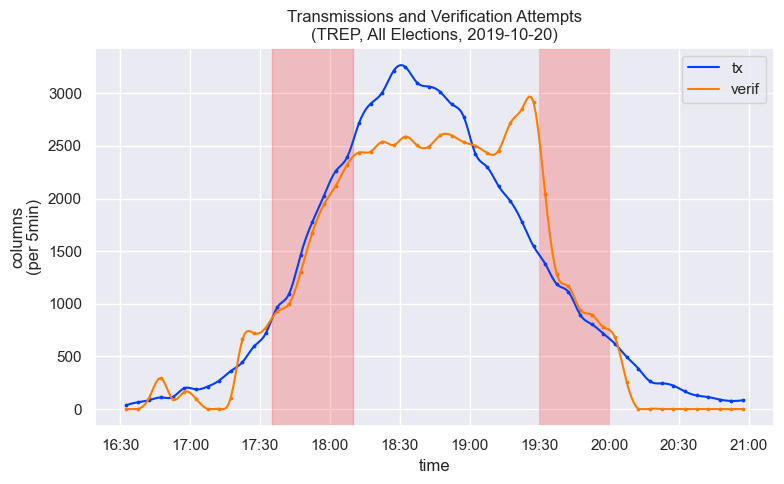

In [2]:
# put tx/verif events in 5-min bins. (important note: 'verif' means verif attempts. most succeed but some fail; i'm interested in both, as analysis is procedural)
trep = trep.drop(index=trep[trep.evt_type == 'aprob'].index) # don't care about approvals (other process).
trep['tx_verif'] = trep.evt_type.where(trep.evt_type == 'tx', 'verif') # tx=golpe1, verif=golpe2. different steps in the process.
events = trep \
    .groupby([pd.Grouper(freq='5min', key='evt_time'), 'tx_verif']) \
    .size().unstack(level=1).resample('5min').asfreq().fillna(0)
events.index += pd.Timedelta('2.5min') # push the points to the middle of 5-min bin intervals.
en_evts = events['2019-10-20 16:30':'2019-10-20 21:00'] # just election night.

# graph the events.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('Transmissions and Verification Attempts\n(TREP, All Elections, 2019-10-20)')
ax.set_xlabel('time')
ax.set_ylabel('columns\n(per 5min)')
smooth_lines_scatter(en_evts, ax, interval='1min', labels=['tx', 'verif'])
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)
ax.legend()
if save_results:
    plt.savefig(path_join('out', '01-tx-verif.png'), dpi=200)

<figure>
    <center>
        <figcaption style="font-size: 75%">Vertical spans are the high-traffic periods. (Note: In the main text, I cite 19:32 as the start of the second high-traffic event, since that's when 'verif' crashes if you use 1-minute bins.)</figcaption>
    </center>
</figure>

If acta column shortages caused verification operators to aggressively poll the application server, then I might also expect that, when verifiers appear to work slower, their traffic rate will increase because they've started to repeatedly ask the application server for work instead of actually working. To check this, first I calculated verifiers’ work rate in 5-minute intervals, taking the number of verification attempts and dividing it by the number of active verifiers. Next, I extracted the data points from EHC's traffic graph and divided bo1’s traffic (=verifs) by bo11’s traffic (=transmits) to show when bo1's traffic was high *relative to transmits*, since Marcel Guzmán de Rojas claimed that high bo1 traffic only reflected a high transmit rate. Finally, I plotted the two ratios against each other. The resulting graph confirms the prediction that decreases in verifiers’ work rate coincide with increases in their traffic rate:

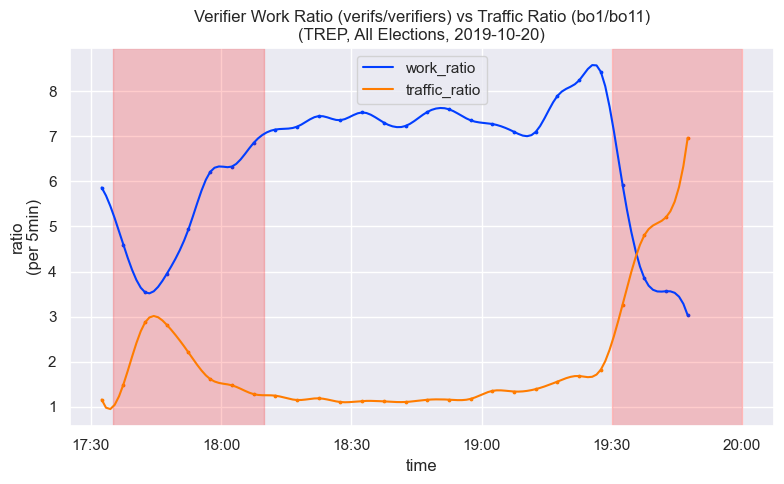

In [3]:
# calculate verifier stats per 5min (verification_attempts, active_verifiers)
work = trep[trep.tx_verif == 'verif'] \
    .groupby(pd.Grouper(freq='5min', key='evt_time')) \
    .pipe(lambda x: pd.DataFrame({'verifs': x.size(), 'verifiers': x.VerificadorUser.nunique()})) \
    ['2019-10-20 16:00':'2019-10-20 20:30'] # just election night.
work['work_ratio'] = np.where(work.verifs > 0, work.verifs / work.verifiers, 0)

# join to ehc's traffic data.
wt = work.join(traffic, how='inner')
wt.index += pd.Timedelta('2.5min') # push the points to the middle of 5-min bin intervals.
wt['traffic_ratio'] = np.where(wt.ehc_bo11_all > 0, wt.ehc_bo1_all / wt.ehc_bo11_all, 0)

# graph work_ratio (=verifs/verifiers) vs http_ratio (=bo1/bo11).
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('Verifier Work Ratio (verifs/verifiers) vs Traffic Ratio (bo1/bo11)\n(TREP, All Elections, 2019-10-20)')
ax.set_xlabel('time')
# note: i stopped traffic before 19:50 because ehc's data for 19:50 onward seems super incorrect (comparing to bisite's bo1 numbers).
smooth_lines_scatter(wt[:'2019-10-20 19:47:30'], ax, interval='1min', labels=['work_ratio', 'traffic_ratio'])
ax.set_ylabel('ratio\n(per 5min)')
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)
ax.legend()
if save_results:
    plt.savefig(path_join('out', '02-work-traffic.png'), dpi=200)

<figure>
    <center>
        <figcaption style="font-size: 75%">I cut it off right before 19:50 because that's when EHC's data stops lining up with BISITE's data. Again, I'm fairly sure EHC's monitoring software started to choke between 19:50-19:55.</figcaption>
    </center>
</figure>

The graphical evidence is highly consistent with polling-driven traffic increases, but it’s also important to analyze the specific HTTP requests behind the traffic increases. However, I don’t have the HTTP logs, so I have to rely on what’s in the IT reports. The BISITE audit said the traffic increases were due to requests for acta verifications (BISITE, p91), which EHC and NEOTEC also indicated in their 2019 reports. The BISITE auditors didn’t specify the exact name of the requests behind the increases, but at the start of that section of their report (BISITE, p69), they defined acta verification requests as ones to the endpoint <code>/process/VerificaActa/VerificaProxima</code> (=<code>/process/VerifyActa/VerifyNext</code>), whose name is suggestive of a polling mechanism. BISITE's findings match EHC's private report, which contains a <a href="https://images2.imgbox.com/5c/7e/OdYfiUQ2_o.jpg">log fragment</a> from the start of the second high-traffic period in which most requests from bo1 to bo2 at the time were these same VerificaProxima requests. The findings also align with the OAS audit, which cited VerificaProxima as, by far, bo1's most common request to bo2:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/05-oas-http-frequency.png" height="60%" width="60%">
        <figcaption style="font-size: 75%">Warning: This chart excludes a lot of important and common HTTP requests from bo1 to bo2. To create the chart, all the OAS did was exact-match the request URLs, so they only captured a bunch of POSTs with identical URLs.</figcaption>
    </center>
</figure>

So, traffic increased when verification operators started to send more and more of an HTTP request named VerificaProxima, which seems to be a request for an acta column to transcribe. But how exactly did VerificaProxima work? Well, I think I know. A week and a half before the election, there were two public demos of the TREP before political representatives, journalists, and other interested observers. During the <a href="https://youtu.be/BtI4_d29HnA?t=1650">first</a> demo, Marcel Guzmán de Rojas transcribed sample acta columns, showing the process from the perspective of the verification operator. In video of the event, he's presented with an acta image and text boxes for his transcription. He transcribes the vote totals from the appropriate column on the acta, then clicks a check-mark box to submit his transcription:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/06-trep-demo-click.png"/>
    </center>
</figure>

His transcription matches the one that's already on the application server, so the acta image and text boxes vanish and a new button appears:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/07-trep-demo-verificaproxima-wide.png"/>
        <img src="./data/imgs/post-imgs/08-trep-demo-verificaproxima-close.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Clicking ’Verifica próxima’ causes the client's browser to ask the server for another acta column to transcribe.</figcaption>
    </center>
</figure>

It's a bit hard to read, but the button says '<a href="https://youtu.be/zwEyZ6hIzzY?t=985">Verifica próxima</a>'. This button is the source of the VerificaProxima HTTP requests that were responsible for the high-traffic events. Each time a verifier clicked the ‘Verifica próxima’ button, their browser sent a VerificaProxima HTTP request to bo2 (via bo1). Therefore, increases in the rate of VerificaProxima requests actually reflect increases in the rate of ‘Verifica próxima’ clicks. Given this, the question about the high traffic can be reframed: What caused verifiers to start clicking 'Verifica próxima' more and more?

To answer that, it’s helpful to observe the verification process in a <a href="https://youtu.be/sn7Zna00l7I">loop</a>:

<center>
    <video controls src="./data/vids/verif-video.mp4"/>
    <figure>
        <figcaption style="font-size: 75%">During transcriptions, the buttons are ‘✓' (=[Submit]), ‘x’ (=[Reject]), and ‘Invierte imagen' (=Invert image). If the submitted transcription doesn’t match, then '✓ con diferencias' (=[Submit] with differences) appears too. However, between transcriptions there's only one labeled button: 'Verifica próxima'.</figcaption>
    </figure>
</center>

After the video's final transcription, Marcel Guzmán de Rojas clicks 'Verifica próxima' like before but instead of receiving another acta column to transcribe, a red warning message pops up:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/09-trep-demo-red-warning.png"/>
        <figcaption style="font-size: 75%">A red warning message, the result of a 'no columns' response to a VerificaProxima request after the demo’s application server ran out of verification-elegible acta columns. (Note: The cursor is on the out-of-frame 'Verifica próxima' button. The object in the middle of the screen is a visual artifact that appears after a completed transcription, as can be seen at 0:20 of the video, for example.)</figcaption>
    </center>
</figure>

This red warning message appears on a verifier's screen when they click 'Verifica próxima' but get a 'no columns' response from the application server instead of a column to transcribe. I know this partly from context clues (*"¡Listo!"*), but also because, at <a href="https://youtu.be/BtI4_d29HnA?t=2158s">another point</a> in the same demo, Marcel Guzmán de Rojas presses the ‘Verifica próxima‘ button, a red warning message appears, and then he declares, *"No tengo actas. Ahorita van a llegar"* (="I have no actas. They'll arrive in a moment"). The warning is also visible in a photo from the OAS's 2019/2020 EOM report. It reads, *“No quedan actas para verificar. Revise nuevamente en 1 minuto”* (="There are no actas left to verify. Check again in 1 minute"):

<figure>
    <center>
        <img src="./data/imgs/post-imgs/10-oas-red-warning.png" height="60%" width="60%" />
        <figcaption style="font-size: 75%">Photo taken by an OAS observer at the SERECI offices on Election Night after the SERECI's internet was cut, which is why all the other warning messages have to do with internet problems. Also, an observation: The lights are still on in the background, so I don’t know what to make of claims that the SERECI’s power was cut too. (Source: OAS 2019/2020 EOM Report, p73)</figcaption>
    </center>
</figure>

So, when the verification operator clicked the 'Verifica próxima' button, their browser sent a VerificaProxima HTTP request to bo2 (via bo1). When bo2 had columns for them to transcribe, clicking 'Verifica próxima' got the user another one, but when bo2 didn't have any columns to transcribe, clicking it got them the red warning message. A verifier who received a column would've spent, on average, about 40 seconds transcribing it before clicking 'Verifica próxima' again, but one who received the warning message would've continued to click 'Verifica próxima' in anticipation of new columns becoming available, ignoring the instruction to wait a minute before clicking again. On Election Night, traffic began to spike once users encountered an acta shortage because the shortage caused the warning message to start to appear, so users went from calmly clicking ‘Verifica próxima’ once every 40 seconds to impatiently clicking it over and over, with each click causing their browser to send an HTTP request to bo2 (via bo1). As the shortage worsened, users saw the warning more and more often, so they clicked ’Verifica próxima’ more and more, until eventually the shortage abated, the users backed off, or, as occurred here, someone disrupted their internet connection.

There’s a basic sanity test you can run on this interpretation. The BISITE audit reported that, between 17:30 and 20:00, the max number of ‘verification’ (=VerificaProxima) requests from bo1 to bo2 in a 5-minute period was 25,764 requests between 19:55-20:00 (BISITE, p91). There were 350 verification operators, so at their peak each verifier would've clicked the 'Verifica próxima' button once every 4.08 seconds on average, which sounds plausible to me.

Finally, have a look at NEOTEC's 2019/2017 comparison again:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/03-neotec-2017-2019.png" height="60%" width="60%"/>
        <figcaption style="font-size: 75%">Notice how ∫ tx - verif, (while tx > verif) ≈ ∫ verif - tx, (while verif > tx)? That's the backlog being built up, then drawn down.</figcaption>
    </center>
</figure>

The 2017 TREP has the same ‘transmit_rate ≈ verif_rate' periods as 2019: one at the start when verifiers matched the initial ramp-up in transmits and one at the end after verifiers exhausted the backlog that had built up. The second ‘transmit_rate ≈ verif_rate' in 2017 was surely accompanied by a traffic spike similar to the one that sparked the 2019 crisis, but in 2017 it came and went without incident.

## Other Explanations ##

There were two accounts of the traffic increase from direct participants. One came from EHC's CEO Alvaro Andrade, whose private report to the TSE said that before the press conference, the TSE asked NEOTEC for a private look at the TREP results and, to comply with this request, NEOTEC sent results to the bo1 server, which housed not only an nginx reverse proxy but also <a href="https://images2.imgbox.com/db/bd/b5nydVzg_o.png">databases</a> with a mix of historical and test data and a Tomcat/SIMOBOL server to view that data. This version from EHC is a bit different from their later public report, which also pointed to the preview but said the spike was due to a redirection of verification traffic. I think that on Election Night, Guzmán de Rojas must’ve reflexively told Andrade and others that the increase was due to results traffic from the preview, but Andrade rejected this because his firm monitored that traffic and knew the requests were for verifications. Later in EHC’s public report, Andrade tried to mash the two explanations together, conflating results traffic with verification traffic and claiming that the latter had been ‘redirected’ too.

The other account came from TSE Vice President Antonio Costas, whose explanation shares elements with the accounts in EHC's reports. In press interviews after his resignation, Costas said the traffic increase was related to his colleagues' request to preview the results, with Costas specifically identifying the migration of electoral data from bo2 to bo1 as the cause. For example, in his Unitel <a href="https://youtu.be/b7LoxDrBJk8?t=199">interview</a>, Costas said *'se migró una parte de los datos para publicarlos a otro servidor'*. (='Part of the data was migrated in order to publish it to another server.') Likewise, in his CNN <a href="https://youtu.be/TKA3HwFGLhk?t=1361">interview</a>, Costas said, *'se hizo una migración hacia un reservorio, hacia un servidor que no estaba contemplado en el área de información que estaba controlada.'* (='There was a migration to a (data) reservoir, to a server [bo1] that wasn't part of the controlled IT infrastructure.') That is, some TREP data was copied from bo2 to bo1 to allow his colleagues to preview the election results, and this is what caused the traffic increase.

None of these are correct, though. The BISITE audit indicates that the HTTP spikes were driven by verification traffic, not results traffic. Specifically, results traffic was only 0.91% of bo1's requests to bo2 between 17:30-20:00 (BISITE, p91). Second, verification requests weren’t redirected from another source because bo1 was the only source of ‘verification’ traffic on Election Day (BISITE, whole report). Furthermore, if the increase were due to the redirection of verification traffic or the migration of election results, then you might expect a sudden, one-time traffic jump, not steady traffic increases over 20 minutes or so, which are better explained by verifiers clicking 'Verifica próxima' more and more as slack in the verification process increased. Lastly, all their explanations are specific to the traffic increase at 19:30 and can't explain a similar event two hours earlier.

## The Limits of the <a href="https://www.reddit.com/user/srslyjuststop/comments/rl7m4u/guide_to_the_2019_trep_actalog/">ActaLog</a> Data ##

I'm certain that the explanation I gave is correct, but there was one test I ran that didn’t give me the results I expected. In the description I gave, it's helpful to think of bo2's unprocessed acta columns as a sort of pool. This pool grows with acta column transmissions but shrinks with verification attempts. HTTP traffic spikes occur when the pool is empty and no columns are available for verifiers to transcribe, so the verifiers ask the application server for work over and over. To test this interpretation, I took the data from bo2's ActaLog and tracked the status of each acta column over the course of the count under the assumption that, in a given moment, the pool is the set of acta columns with a current status of 'Registrada'. During traffic spikes, the number of such columns should be effectively zero. But when I checked, it wasn't zero:

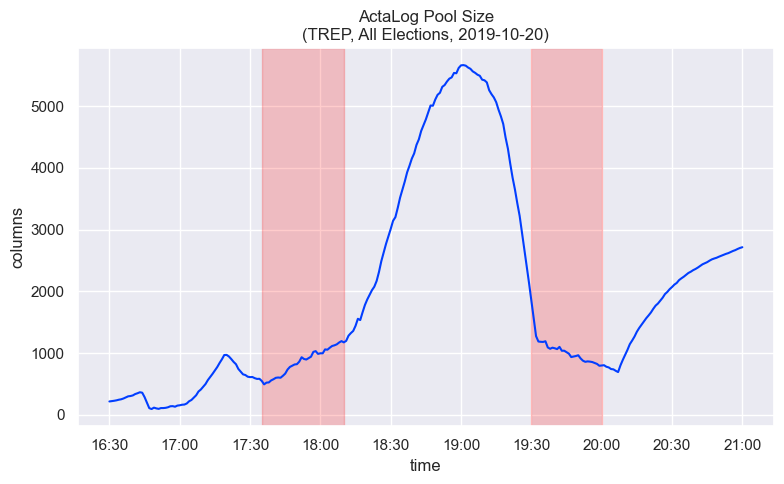

In [4]:
# calculate pool. (using closed interval)
pool = trep \
    .drop_duplicates(subset=['col_id', 'tx_verif'], keep='first') \
    .groupby(['evt_time', 'tx_verif']) \
    .size().unstack(level=1).fillna(0) \
    .pipe(lambda x: x.tx.cumsum() - x.verif.cumsum()) \
    .resample('1min').ffill() \
    ['2019-10-20 16:30':'2019-10-20 21:00']

# graph pool
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('ActaLog Pool Size\n(TREP, All Elections, 2019-10-20)')
ax.set_xlabel('time')
ax.set_ylabel('columns')
ax.plot(pool, label='pool')
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)
if save_results:
    plt.savefig(path_join('out', '03-pool-actalog.png'), dpi=200)

When the traffic spikes occur, the surplus pool is low in relative terms, but it’s still around 1000 columns, not zero, and the number of 'transmitted but unavailable' columns slowly increases or decreases depending on the moment. Despite this, I have no doubts about the VerificaProxima polling interpretation. There’s far too much evidence to support it. So, I figure my definition of the surplus pool is too broad. For the graph above, I counted all acta columns with a current status of 'Registrada' according to bo2’s ActaLog, but evidently there was more to it than that. How did VerificaProxima define which columns were eligible for verification, then?

To start, I think it's reasonable to assume VerificaProxima would've only picked an acta column for verification if the server's database had the basic elements needed to attempt a verification. At minimum, this would mean: 1) an acta image to transcribe, and 2) an initial transcription to compare against the verifier’s transcription. You might think that if the server's database had the initial transcription, then it must‘ve had a photo too, but that’s not true. The two were separate, which is clear from the screenshot uploaded to the TREP mobile app's <a href="https://play.google.com/store/apps/details?id=com.guzral.simoregacta">Google Play page</a> ('TR/TRImg'). It’s just that in the TREP, unlike the Cómputo, the same user was responsible for recording and sending both pieces of data. The initial transcriptions were sent to bo2 (via bo11) as *registroActa* requests (BISITE, p69) and stored in the Acta table (BISITE, p164; ActaLog can be used to reconstruct Acta), whereas the acta images were sent to bo2 (via bo11) as *registroImagenActa* requests and stored in the ActaImagenLog table, which I don't have at all. (Note: BISITE also mentions an ActaImagenError table.) That's a serious problem. An acta column that appears to be verification-eligible based on the Acta table might have a missing or invalid record in the ActaImagen tables, so VerificaProxima would skip over it.

There’s evidence that VerificaProxima really did enforce this condition. While I don’t have SIMOBOL‘s source code, there’s a revealing snippet of it visible in EHC’s report:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/11-ehc-catalina-log.png" />
        <figcaption style="font-size: 75%">Entries are in reverse chronological order. (Source: EHC Public Report, p34)</figcaption>
    </center>
</figure>

In the Tomcat log above, there's a JDBC exception caused by a malformed SQL statement that the application server tried to execute while processing a request called ComputoProxima, which is a Cómputo-specific variant of VerificaProxima. The visible fragment of the bad SQL statement suggests that ComputoProxima (and VerificaProxima) picked acta columns for verification by selecting records with verification-eligible status values from the Acta table (aliased as 'a') and matched them by polling station ID against the records in the ActaImagenLog table. In other words, VerificaProxima only selected acta columns that had both a transcription **and** an image. I only have the Acta table (as ActaLog), so all I can do is track whether an acta column had a transcription available, not whether it had an image too, which would require ActaImagenLog (and perhaps ActaImagenError as well).

I strongly suspect the explanation for most of the ‘transmitted but unavailable’ acta columns lies with these ActaImagen tables. And while I don't have those tables, I do have a method to get around the problem somewhat: Use my Cómputo data instead. After bo2 received an acta image for an overseas polling station, it queued the image for replication not only to the TREP’s bo2s server but also to a Cómputo gateway named oep1 (BISITE, p154) and the times of these image replications are in a Cómputo dataset I have. Since it was bo2 which sent the images to oep1, bo2 must've already had the images, so the Cómputo image transmission times can serve as an upper-bound on when bo2 received the image. As a lower bound, you can shave a minute from that same time, since, per Marcel Guzmán de Rojas's statement to authorities (*Sobreseimiento*, p22), the replication process ran once a minute. Therefore, bo2 must've received the photo between the previous run (replication timestamp minus one minute) and the current one (replication timestamp). A serious problem with this, though, is that only overseas acta images were replicated to the Cómputo, and these represent just 4.36% of all actas in the election. Furthermore, it's certain there are additional updates to bo2's ActaImagen tables not reflected in the Cómputo timestamps, so it only provides an incomplete picture of what happened to the acta images on bo2. But still, it has value, because if missing acta images explain the 'transmitted but unavailable' actas from overseas, they likely explain the domestic ones, too.

To examine the effect of these image times, I made another pool graph, but this time I narrowed my focus to the 1452 acta columns whose images were replicated from bo2 to oep1. I calculated pool size with two approaches. In the first, I counted acta columns with a status of ‘Registrada’ like before, but in the second, I started to count them within these bounds:

<code>pool_start_lo = max(actalog.first_transcript_tx, computo.first_img_tx - 1minute)</code>

<code>pool_start_hi = max(min(max(actalog.first_transcript_tx, computo.first_img_tx), actalog.verif - min_transcribe_time), pool_start_lo)</code>

And, of course, I stopped counting them at:

<code>pool_end = actalog.verif</code>

(Note: <code>min_transcribe_time</code> = 15 seconds. And no, the image transmission times aren't just slow, as I show in the Python notebook.)

Finally, I plotted the results, providing a range of values for the second pool estimate:

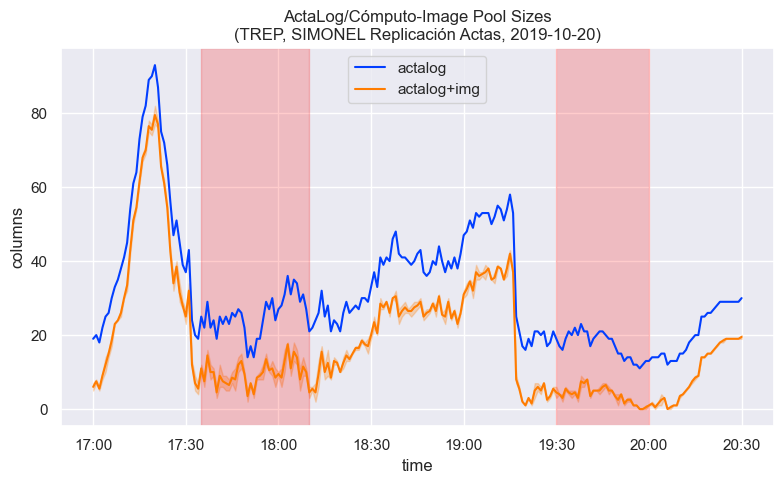

In [5]:
# get acta columns where img transmission ip is bo2's public ip address.
bo2_pub_ip = '3.231.68.158'
comp_img_times = computo.loc[
    (computo['IP Primera Transmisión Imagen'] == bo2_pub_ip),
    ['Primera Transmisión Imagen', 'Ultima Transmisión Imagen', 'IP Ultima Transmisión Imagen']
]

# if an acta's first tx is from bo2 but its second tx isn't, then i use first tx's time for the second tx.
comp_img_times['Ultima Transmisión Imagen'] = comp_img_times['Ultima Transmisión Imagen'].where(
    comp_img_times['IP Ultima Transmisión Imagen'] == bo2_pub_ip,
    comp_img_times['Primera Transmisión Imagen']
)

# drop ip field and rename columns for convenience.
comp_img_times = comp_img_times \
    .drop(columns='IP Ultima Transmisión Imagen') \
    .rename(columns={
        'Primera Transmisión Imagen': 'comp_img_first',
        'IP Ultima Transmisión Imagen': 'comp_img_first_ip',
        'Ultima Transmisión Imagen': 'comp_img_last'
    })

# side note: *all* the times in the computo file are only granular to the minute, not just the img replication times. kind of a pain.

# get various timestamps and id fields for the actas in the subset i'm gonna look at.
img_times = trep[trep.col_id.isin(comp_img_times.index)] \
    .pivot_table(index='col_id', columns='tx_verif', values='evt_time', aggfunc='first') \
    .rename(columns={'tx': 'tx_first'}) \
    .join(computo[['NumMesa']], how='left') \
    .join(comp_img_times, how='left')

# some static values for calculations below.
img_col = 'comp_img_first' # which img timestamp to use? (first or last?)
verif_col = 'verif' # what verif timestamp to use? (might create a second verif timestamp in next section)
min_transcribe_time = pd.Timedelta('15s') # what's minimum time between entering pool and a verifier transcribing it?

# simple guess at when an acta was served out.
transcribe_time = pd.Timedelta('30s') # guessing it typically takes 30s to transcribe.
img_times['served'] = img_times.verif - transcribe_time

# option to remove a column from pool once i think it's probably been served out.
# idea is that system probably doesn't serve the same acta col to multiple people at the same time, which would duplicate work.
# so, use 'served' time instead of 'verif' and eliminate min_transcribe_time to capture when i'd guess that, on average, the acta was served out.
use_served = False
if use_served:
    verif_col = 'served'
    min_transcribe_time = pd.Timedelta('0sec')

# lo estimate on when acta col entered pool
img_times['pool_earliest'] = img_times.apply(
    lambda x:
    min(
        max(
            x.tx_first, # actalog first transmission timestamp.
            x[img_col] - pd.Timedelta('1min') # time of previous image replication run.
        ),
        x[verif_col] # actalog verif timestamp. only relevant to the edge case where use_served==True, avoiding situation where served is *before* pool_earliest.
    ),
axis=1) # yes, i could write this in a less readable but vectorized way.

# hi estimate on when acta col entered pool
img_times['pool_latest'] = img_times.apply(
    lambda x:
    max(
        min(
            max(
                x.tx_first, # actalog first transmission timestamp.
                x[img_col]  # time of current image replication run.
            ),
            x[verif_col] - min_transcribe_time # actalog verif timestamp, but given a little breathing room to account for time it takes to transcribe acta.
        ),
        x.pool_earliest # making sure pool_latest isn't before pool_earliest.
    ),
axis=1) # yes, i could write this in a less readable but vectorized way.

# some other calculations.
img_times['actalog_time_to_verif'] = img_times[verif_col] - img_times.tx_first # old actalog-based duration between tx and verif event
img_times['new_time_to_verif'] = img_times[verif_col] - (img_times.pool_earliest + ((img_times.pool_latest - img_times.pool_earliest) / 2.0)) # take midpt of earliest/latest...
img_times['is_comp_multi_send'] = (img_times.comp_img_first != img_times.comp_img_last) # seem to have been sent multiple times?

# order rows and columns
img_times = img_times.sort_values('actalog_time_to_verif', ascending=False) # longest waits first, based on actalog.
img_times = img_times[f"NumMesa|tx_first|comp_img_first|comp_img_last|pool_earliest|pool_latest|served|verif|actalog_time_to_verif|new_time_to_verif|is_comp_multi_send".split('|')].copy()

# save me
if save_results:
    img_times.to_csv(path_join('out', 'img_times.csv'))
    
# function to recalculate pool based on img_times df
def recalc_pool(start_col, end_col, df=img_times, freq='1min'):
    return pd.merge(
        pd.Series(df.groupby(start_col).size(), name='in_pool'),
        pd.Series(df.groupby(end_col).size(), name='out_pool'),
        how='outer',
        right_index=True,
        left_index=True
    ).sort_index() \
    .fillna(0) \
    .pipe(lambda x: x.in_pool.cumsum() - x.out_pool.cumsum()) \
    .resample(freq).ffill()

# make the pool calculations
pools = pd.DataFrame({
    'actalog_pool': recalc_pool('tx_first', 'verif'),
    'computo_hi_pool': recalc_pool('pool_earliest', verif_col),
    'computo_lo_pool': recalc_pool('pool_latest', verif_col),
})['2019-10-20 17:00':'2019-10-20 20:30']

# add simple pool reduction metric (about 70% reduction during second high-traffic period), then save.
pools['pool_reduction_pct'] = (pools.actalog_pool - pools[['computo_lo_pool', 'computo_hi_pool']].mean(axis=1)) / pools.actalog_pool
if save_results:
    pools.to_csv(path_join('out', 'pools.csv'))

# finally, make the new pool graph.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('ActaLog/Cómputo-Image Pool Sizes\n(TREP, SIMONEL Replicación Actas, 2019-10-20)')
ax.set_xlabel('time')
ax.set_ylabel('columns')
ax.plot(pools.actalog_pool, label='actalog') # basic actalog-based pool calc
ax.plot(pools[['computo_lo_pool', 'computo_hi_pool']].mean(axis=1), label='actalog+img') # new pool calc. just taking midpoint of hi/lo calculations. should i bother doing more?
ax.fill_between(pools.index, pools.computo_lo_pool, pools.computo_hi_pool, alpha=0.25, color=ax.lines[-1].get_color()) # give hi-lo range (fairly tight)
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)
ax.legend(loc='upper center')
if save_results:
    plt.savefig(path_join('out', f"04-pool-computo{f'-served_{int(transcribe_time.total_seconds())}s' if use_served else ''}.png"), dpi=200)

<figure>
    <center>
        <figcaption style="font-size: 75%">Notice how the pool suddenly bottoms out 15 minutes *before* 19:32? It's because all 1452 actas in the subset are from overseas and the overseas pool was suddenly drawn down at 19:16-19:17 (see: 'Regional Verification Spikes')</figcaption>
    </center>
</figure>

The new Cómputo-based estimate suggests that most 'transmitted but unavailable' columns during high-traffic periods were unavailable for verification due to issues with their photos. Specifically, the difference between the plots is, by design, attributable to actas whose photo wasn't yet on bo2, so VerificaProxima wouldn’t have considered them for verification. In bo2's ActaLog data, these acta columns looked verification-eligible, but the Cómputo data implies they weren't.

Still, the new estimate isn’t quite zero. I don't think it’s a big problem, though. My sense of it is that there are two elements to consider. First, in the pool size calculation, I treat a column as in the surplus pool once bo2 has a photo and an initial transcription for it, and out of the pool once a verifier's transcription is recorded. However, even in the ideal case in which the column is served out as soon as a transcription and photo are available, there's still the time it takes the verifier to transcribe it. While the column is being transcribed, it's still treated as in the pool, even though it's almost certainly unavailable to other verifiers. It follows that the max number of such columns at one time is the number of active verifiers (350), so during a shortage in an active vote count I should expect 0-350 columns, not zero. (Earlier, I enforced a crude minimum bound on this transcription time with <code>min_transcribe_time</code>.) There's still a small number of other cases unaccounted for by this explanation, but I think they might be due to a poorly-documented review process for bad actas. I don't have the space to explain here, though, so I put my observations in the Python notebook.

This analysis would be much simpler if I had the missing ActaImagen tables, but that'll never happen. To be honest, I'm surprised I even got my hands on bo2's ActaLog table. I tried and failed to get it in early 2020 and was just fortunate someone else shared it with me later. Despite the missing data, I‘m very confident in the 'Verifica proxima' button-clicking interpretation. It's sensible and closely matches the evidence. I don’t have the tables for the full surplus pool estimate, but I don’t think I need them because my other arguments are so strong. Plus, when I limited the pool estimate to the few actas I do have image timestamps for, I was able to show that it was practically empty during the high-traffic periods. So, as far as I’m concerned, the ‘Verifica próxima’ explanation isn’t just some theory but an established fact about what occurred. It should be better-known since it was the <a href="https://eldeber.com.bo/usted-elige/30000-solicitudes-de-validacion-alertaron-sobre-el-fraude-en-las-elecciones-de-2019_203594">*detonante*</a> of the mess on Election Night, but I doubt it’ll ever be repeated outside of my posts.

## Regional Verification Spikes ##

Issues with acta images were one way columns might falsely appear eligible for verification based on the ActaLog data, but it wasn’t the only one. There was a second, distinct form of it that's inessential to the explanation of the bo1 traffic increase but which I thought I'd describe all the same. Between the two ‘transmit_rate ≈ verif_rate' periods on Election Night, many columns in bo2's backlog appear to have been ineligible for verification for long periods of time and, when they finally were verified, these verifications occurred in unusual patterns. The best-known case of this was a rush of verifications of presidential columns from the department of Santa Cruz:

In [6]:
# utility function for tx-verif plots split by election type.
elex_aliases = {'Presidente y Vicepresidente': 'prez', 'Diputados Uninominales': 'dip-uni', 'Diputados Especiales': 'dip-esp'}
elex_order = [(e, p) for e in elex_aliases.values() for p in ['tx', 'verif']]
def get_evts_by_elex(df, start='2019-10-20 16:00', end='2019-10-20 21:00', freq='5min'):
    df = df[['evt_time', 'ElecActa', 'tx_verif']].copy()
    df['ElecActa'] = df.ElecActa.map(elex_aliases)
    df_evts = df \
        .groupby([pd.Grouper(freq=freq, key='evt_time'), 'ElecActa', 'tx_verif']) \
        .size().unstack(level=[1, 2]).resample(freq).asfreq().fillna(0) \
        [start:end]
    df_evts = df_evts[sorted(df_evts.columns.to_list(), key=lambda x: elex_order.index(x))]
    #if mid_bin:
    #    df_evts.index += (pd.Timedelta(freq) / 2)
    df_evts.columns.names = ['election' , 'trep_process']
    df_evts.index.name = 'time'
    return df_evts

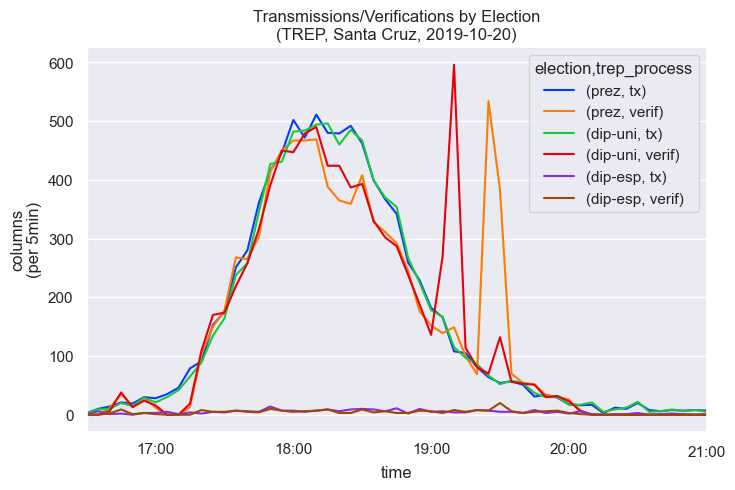

In [7]:
# show santa cruz spikiness.
get_evts_by_elex(trep[trep.Dep == 'Santa Cruz'], start='2019-10-20 16:30').plot(
    title=f'Transmissions/Verifications by Election\n(TREP, Santa Cruz, 2019-10-20)',
    ylabel='columns\n(per 5min)',
    figsize=(8, 5)
)
if save_results:
    plt.savefig(path_join('out', '05-scz-spike.png'), dpi=200)

In a TV interview, EHC’s Álvaro Andrade cited the orange spike from 19:29-19:32 as the cause of the TSE's 'change in trend', claiming that columns from Santa Cruz had 'started to arrive', but those columns, which only reduced the MAS's lead by half a point, had arrived much earlier. They had been sent to bo2 at times scattered throughout the period in the graph when verifications failed to keep pace with transmissions, which started a few minutes after 18:00. The composition of the spikes is quite striking, too, since each one is specific to the region and to an election type, even though VerificaProxima was said to have picked columns at random. Furthermore, if you examine in detail the old columns that formed the basis of the verification spikes, you'll find they were processed roughly in ascending order by polling station identifier. This wasn’t limited to Santa Cruz, either. It occurred everywhere (even overseas), albeit at different times and in different orders:

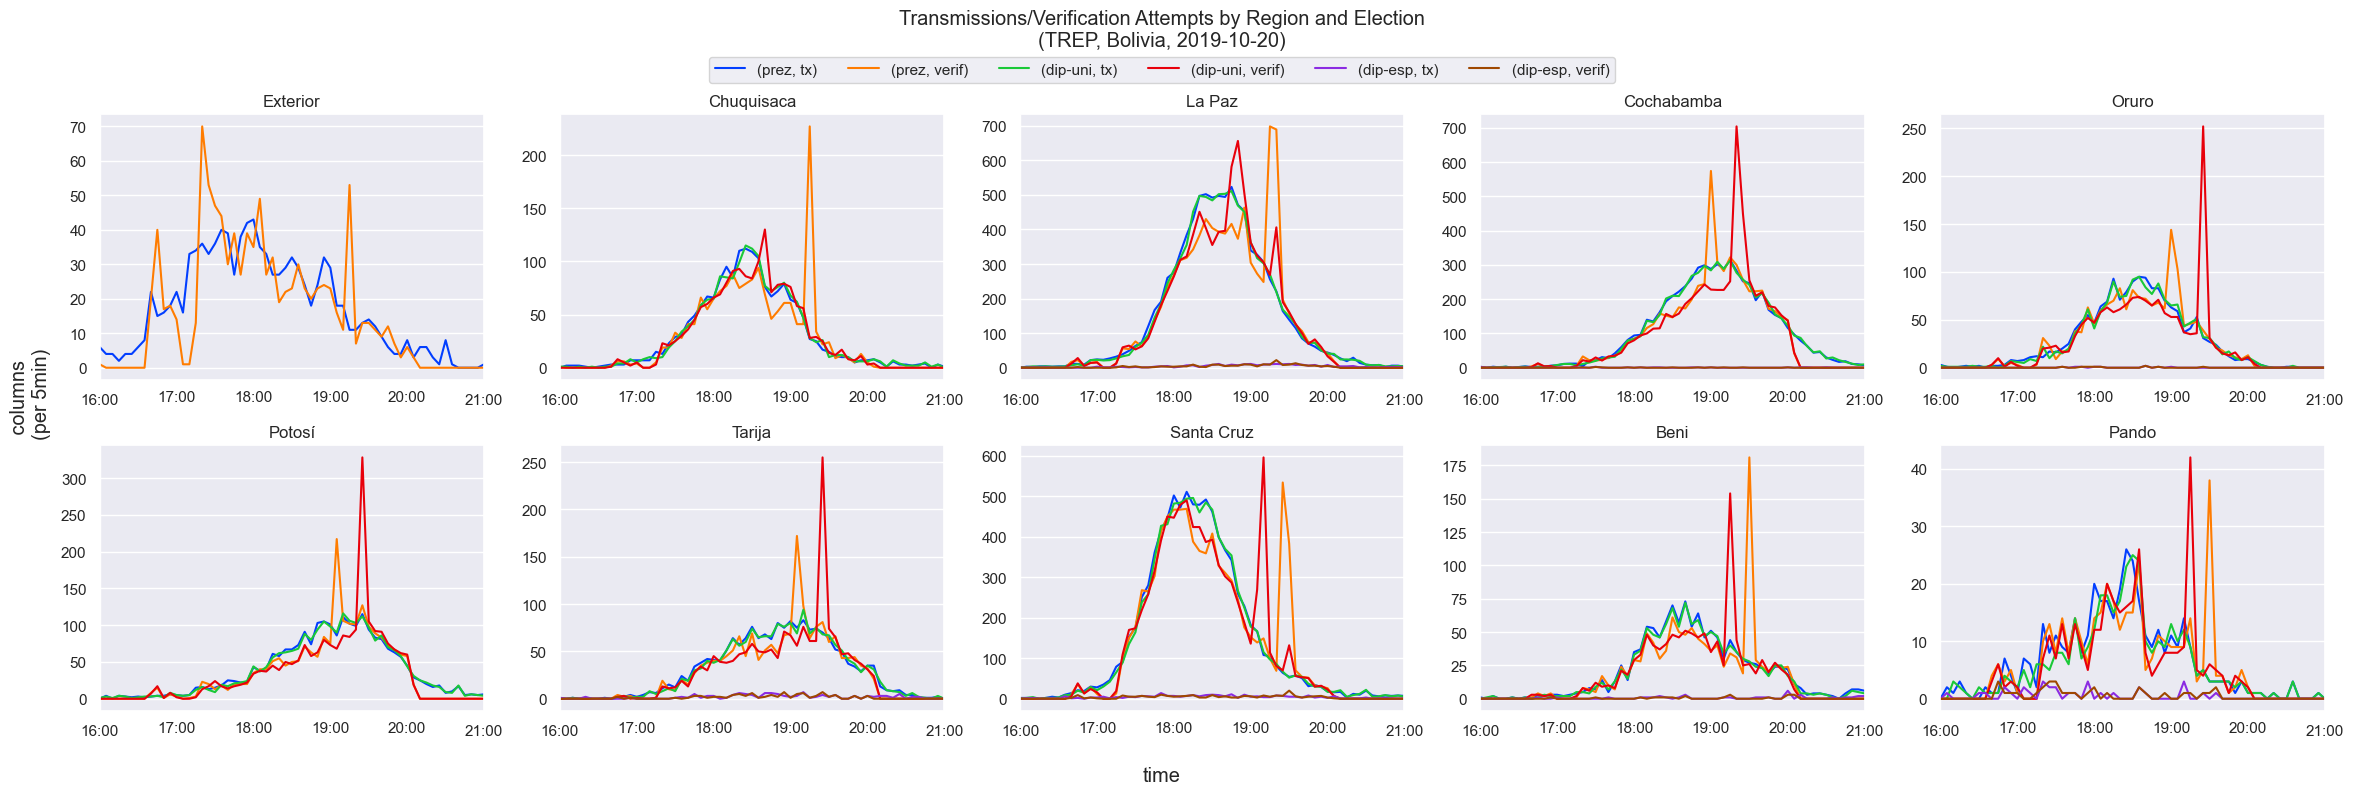

In [8]:
# show all regions
fig, axes = plt.subplots(figsize=(24, 8), nrows=2, ncols=5)
fig.suptitle(f'Transmissions/Verification Attempts by Region and Election\n(TREP, Bolivia, 2019-10-20)')

# overseas. (note: pre-19:00 overseas spikiness is just because sereci was idle, not actually bottleneck event (which occurs at 19:16-19:17))
get_evts_by_elex(trep[trep.Pais != 'Bolivia']).plot(ax=axes[0,0], title='Exterior', legend=False, xlabel='', ylabel='')

# bolivia
dep_names = trep[trep.Pais == 'Bolivia'].sort_values('NumMesa', ascending=True).Dep.drop_duplicates().to_list()
for dep_name, ax in zip(dep_names, axes.flat[1:]):
    get_evts_by_elex(trep[trep.Dep == dep_name]).plot(ax=ax, title=dep_name, legend=False, xlabel='', ylabel='')
    
fig.supxlabel('time')
fig.supylabel(' columns\n(per 5min)\n')
fig.legend(
    handles=axes[0, 2].lines, # la paz has all six plot types. (no ordering issues, since all have prez, and no region has special deputy w/o uninominal deputy)
    ncol=len(axes[0, 2].lines), # display all line legends in single row (use la paz again).
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93)
)
fig.tight_layout(rect=(0, 0, 1, 0.97))
if save_results:
    plt.savefig(path_join('out', '06-regional-spikes.png'), dpi=200)

<figure>
    <center>
        <figcaption style="font-size: 75%">From roughly 18:50-19:30, VerificaProxima seems to draw columns from *two* sources: 1) new transmits picked at random from all regions, and 2) old transmits picked roughly in ascending order by station ID from a ‘current’ region/election. In rough terms, the 2) process seems to exhaust a region/election's backlog of old columns then moves on to the next one.</figcaption>
    </center>
</figure>

I don't know what caused this, but the patterns in the graph are so sharp and well-organized that I figure they must be the programmatic resolution of some bottleneck, perhaps related to fights for database locks, slow disk writes, or who knows what. I don’t know why they’re organized by region and election either, but when I ran this by someone else, they thought the developer might’ve managed this bottleneck so as to equalize coverage across regions/elections. That’s only one possibility, though. No doubt there are others. There's nowhere near enough information to take a position on this, which seems like the kind of problem for which there’s little alternative to reading the source code. Given that, I’m mostly satisfied with having given a fair top-level description of the behavior.

# Additional Analysis #

A few points and observations that I couldn't fit in the post.

### Excess VerificaProxima Requests ###

Earlier I said, "The excess requests [during the high-traffic periods] are actually verification operators' ***unsuccessful* requests** for acta columns to transcribe."

There's a simple way to visualize this: Compare the number of VerificaProxima requests (=BISITE's so-called 'verification' requests) to the number of verification attempts made (according to the ActaLog). When columns are available, the two should be roughly equal, but during shortage periods, there will be more VerificaProxima requests.

So, a simple test: Subtract verification attempts from VerificaProxima requests to get the number of 'excess' VerificaProxima requests.

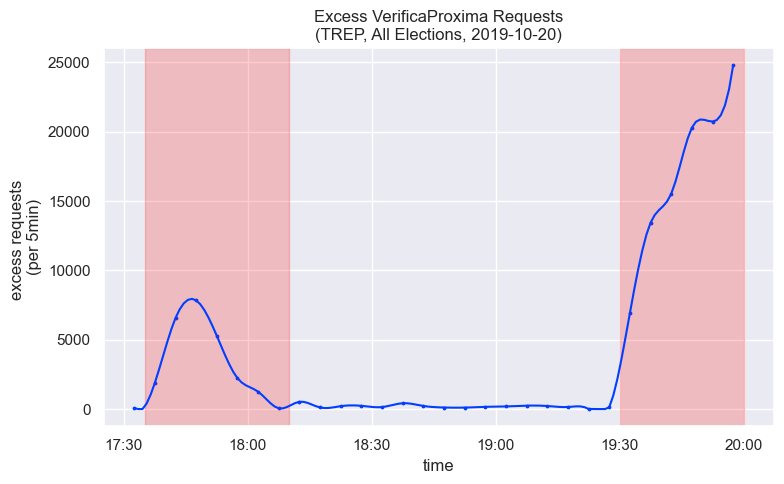

In [9]:
# note: 'bisite_bo1_verif' is bisite's 'verification' (=VerificaProxima) requests. (values extracted visually, so they're only approximate)
# note: 'verif' is the number of verification attempts according to the actalog data.
traffic_shifted = traffic.copy().set_index(traffic.index+pd.Timedelta('2.5min')) # have to shift traffic so it'll join properly to 'events'.
excess = events[['verif']] \
    .join(traffic_shifted, how='inner') \
    .pipe(lambda x: x.bisite_bo1_verif - x.verif) \
    .to_frame().rename(columns={0: 'excess'}) \
    .dropna()

# graph the events.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title("Excess VerificaProxima Requests\n(TREP, All Elections, 2019-10-20)")
ax.set_xlabel('time')
ax.set_ylabel('excess requests \n(per 5min)')
smooth_lines_scatter(excess, ax, interval='1min', labels=['excess'])
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)

👍 (Maybe I should've ended Period #1 earlier?)

### Non-VerificaProxima Traffic Increased a Bit Too ###

The composition of bo1's traffic:

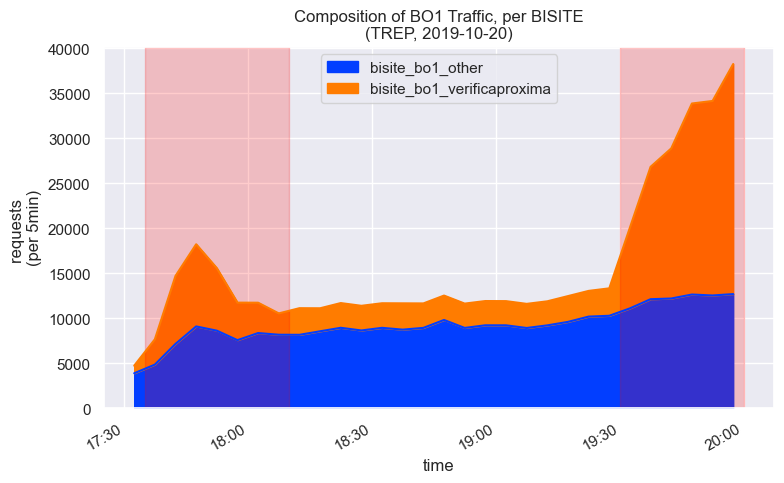

In [10]:
# graph the events.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title("Composition of BO1 Traffic, per BISITE\n(TREP, 2019-10-20)")
ax.set_xlabel('time')
ax.set_ylabel('requests \n(per 5min)')
pd.DataFrame({
    'bisite_bo1_other': traffic_shifted.bisite_bo1_all - traffic_shifted.bisite_bo1_verif,
    'bisite_bo1_verificaproxima': traffic_shifted.bisite_bo1_verif
}).dropna().plot.area(ax=ax)
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)
ax.legend(loc='upper center')

The much smaller increase in non-VerificaProxima requests is... what? Data for the private preview? Who knows.

### The saveAndList and saveAndListConDif Requests ###

BISITE's audit defines 'verification' requests as just VerificaProxima (BISITE, p69), but VerificaProxima wasn't the only verification request. In fact, it wasn't even how users submitted transcriptions. When a user clicked the ‘✓' (=[Submit]) button, their browser sent a <code>/process/VerificaActa/editOnView/saveAndList/xxxxxxx</code> request and when they clicked '✓ con diferencias' (=[Submit] with differences), it sent a <code>/process/VerificaActa/editOnView/saveAndListConDif/xxxxxxx</code> request:

<figure>
    <center>
        <img src="./data/imgs/post-imgs/12-fragment-ehc-first-report.jpg" />
        <figcaption style="font-size: 75%">HTTP log fragment from EHC"s private report. Not sure what <code>/process/VerificaActa/list</code> did.</figcaption>
    </center>
</figure>

The BISITE auditors knew that VerificaProxima wasn't the request that produced acta verifications, otherwise they wouldn't have described them as "peticiones de información y consultas que no implicaban la modificación de datos", but failing to describe <code>saveAndList</code> and <code>saveAndListConDif</code> as 'verification' requests is a mistake, no?

The miscategorization of requests was a recurring issue. On p24 of the *Sobreseimiento* document, Marcel Guzmán de Rojas complained to authorities:
<blockquote>Andrade dice que son 30 mil verificaciones cada 30 segundos, muy bien que esas entraron por BO1, eso es cierto pero haber son 34mil 555 actas en otras palabras y cada acta tiene dos pedazos son 70 mil actas eso significa que en un minuto y 10 segundos se hubieran procesado todas estas actas, eso nunca ocurrió, ósea esa alerta que da Andrade que está equivocada y no sé de dónde se saca esos datos, en los datos que ustedes tienen pueden verificar, les puedo mandar el comando que he usado para mirar el comando que eh usado para mirar el [log] de [nginx] de bo1 y ustedes pueden contar cuantas son y yo lo hice y 85 mil 165 muy bien cómo da cuenta Andrade, porque Andrade no tenia acceso [ethical hacking] no tenía acceso a bo1, so es cierto pero si a bo2 entonces eso implica que todo lo que pasaba por bo1 terminaba en BO2, ósea el podía con solo ver BO2 podía ver todo, y si se mira el log de [nginx], no está en bo2 por que está en bo1 pero el log de [tomcat] si esta y tonkat reporta 170 mil 329 clics de que se quiere guardar una acta para verificar, en [tomcat] son el doble si se fijan son casi exactamente el doble se hace la operación matemática por que en el [tomcat] simonel graba dos lineas por cada petición uno cuando la recibe y otra cuando la responde, en la que responde también dice cuanto tiempo se tardó en procesar, lo cual es critico para nosotros, nosotros necesitamos saber si el sistema se está volviendo lento.</blockquote>

Guzmán de Rojas, who wrote SIMOBOL and actually knew how it worked, was probably picking out <code>saveAndList</code>-type requests from the logs because *those* are acta verifications, not realizing that Andrade's 'acta verifications' were mostly <code>VerificaProxima</code> requests (and Andrade was citing the wrong interval, causing even more confusion).

### Minute-Specific Start of 2nd High-Traffic Period ###

Earlier I said, "In the main text, I cite 19:32 as the start of the second high-traffic event, since that's when 'verif' crashes if you use 1-minute bins."

If you track the verification trends around 19:30 but use 1-minute bins, you'll see verifications crash at 19:32 and the focus shifts to much newer acta columns.

In [11]:
# (note: the verif crash lags actual onset of high-traffic event slightly since verif times are *completed* verif attempts, but it's fine)
trep['verif_delay'] = (trep.VerificadorDate - trep.PriTransmisionDate).where(trep.tx_verif == 'verif', pd.NaT)
percentiles = [0.25, 0.50, 0.75]
verifs_around_spike2 = trep[(trep.tx_verif == 'verif') & (trep.evt_time >= '2019-10-20 19:25') & (trep.evt_time < '2019-10-20 19:40')] \
    .groupby(pd.Grouper(freq='1min', key='evt_time')) \
    .pipe(lambda x: pd.DataFrame({
        'verifs': x.size(),
        'verif_delay_mean': x.verif_delay.mean(numeric_only=False).round('s'), # how long from transmit to verif?
        **{f'verif_delay_{int(p*100)}%': x.verif_delay.quantile(p).round('s') for p in percentiles}
    }))

# note: evt_time is the start of the 1-min bin, so 19:32 = [19:32, 19:33).
verifs_around_spike2.style.apply(lambda x: ['background-color:yellow' if v else '' for v in (verifs_around_spike2.index >= '2019-10-20 19:32:00')])

,verifs,verif_delay_mean,verif_delay_25%,verif_delay_50%,verif_delay_75%
evt_time,,,,,
2019-10-20 19:25:00,603,0 days 00:14:34,0 days 00:00:49,0 days 00:03:37,0 days 00:23:07
2019-10-20 19:26:00,578,0 days 00:18:45,0 days 00:00:55,0 days 00:04:10,0 days 00:36:16
2019-10-20 19:27:00,567,0 days 00:18:14,0 days 00:00:56,0 days 00:04:25,0 days 00:31:55
2019-10-20 19:28:00,583,0 days 00:25:51,0 days 00:01:02,0 days 00:10:48,0 days 00:51:45
2019-10-20 19:29:00,585,0 days 00:29:23,0 days 00:01:12,0 days 00:19:38,0 days 00:59:20
2019-10-20 19:30:00,559,0 days 00:24:50,0 days 00:00:57,0 days 00:06:10,0 days 00:49:15
2019-10-20 19:31:00,591,0 days 00:26:48,0 days 00:01:12,0 days 00:12:33,0 days 00:51:44
2019-10-20 19:32:00,337,0 days 00:10:23,0 days 00:00:43,0 days 00:01:13,0 days 00:04:54
2019-10-20 19:33:00,269,0 days 00:04:33,0 days 00:00:46,0 days 00:01:21,0 days 00:03:23


### EHC's Monitoring Agent Choked Between 19:50-19:55 ###

Earlier, I said, "[At 19:50] EHC's data stops lining up with BISITE's data. Again, I'm fairly sure EHC's monitoring software started to choke between 19:50-19:55."

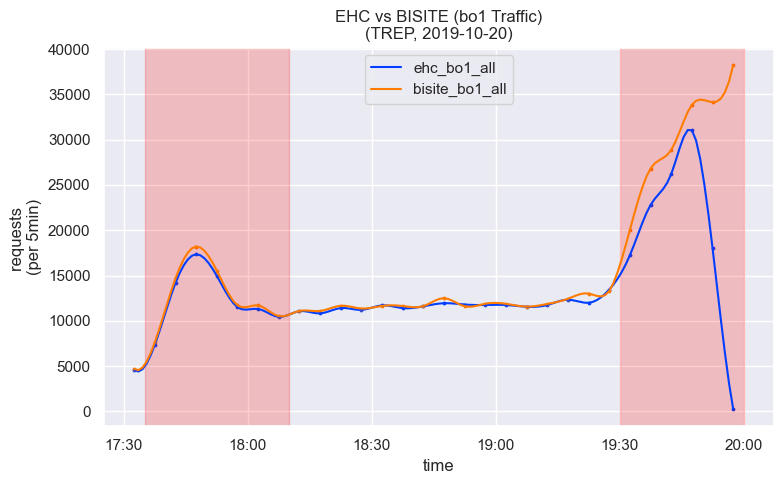

In [12]:
# graph the events.
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title("EHC vs BISITE (bo1 Traffic)\n(TREP, 2019-10-20)")
ax.set_xlabel('time')
ax.set_ylabel('requests \n(per 5min)')
smooth_lines_scatter(wt[wt.notna().all(axis=1)], ax, interval='1min', labels=['ehc_bo1_all', 'bisite_bo1_all']) # 'ehc_bo11_all' < add to see bo11.
add_high_traffic_bars(ax)
ax.xaxis.set_major_formatter(time_format)
ax.legend(loc='upper center')

BISITE's data is more reliable because they worked with the server's actual log files, whereas EHC only had whatever their monitoring agent managed to report back in real time. Based on the comparison graph above, I'd say EHC's monitoring agent choked between 19:50-19:55. (EHC's bo11 traffic rate crashes to zero around the same time, too.)

### The SERECI's Backup Line Activated Eight Minutes Before Their Internet Was Cut ###

Earlier, I identified 200.75.161.30 as the SERECI's backup line.

Here is a list of all the IP addresses used in the basic verification process:

In [13]:
 # focusing on basic verification process (ignoring reviews)
sereci = trep[trep.tx_verif == 'verif'].copy()
sereci['nth_event'] = range(1, len(sereci) + 1)
ip_shift = sereci.loc[ # finding where the ip address changes from one evt to the next (they're in chronological order)
    (sereci.VerificadorIP != sereci.VerificadorIP.shift(1)) | (sereci.VerificadorIP != sereci.VerificadorIP.shift(-1)),
    ['evt_time', 'VerificadorIP', 'nth_event']
].rename(columns={'evt_time': 'start_time', 'VerificadorIP': 'ip', 'nth_event': 'verif_evts'})
ip_shift[['end_time', 'verif_evts']] = ip_shift[['start_time', 'verif_evts']].shift(-1) # current entry's end = next entry's start.
ip_shift['duration'] = ip_shift.end_time - ip_shift.start_time
ip_shift = ip_shift['start_time|end_time|duration|ip|verif_evts'.split('|')][::2].copy().reset_index(drop=True) # reorder columns, drop rows that end ip periods.
ip_shift.verif_evts = (ip_shift.verif_evts - ip_shift.verif_evts.shift(1)).fillna(ip_shift.verif_evts).astype(int) # calculate right number of events based on 'nth_event' numbers.
ip_shift.style.apply(lambda x: ['background-color:yellow' if v else '' for v in (ip_shift.ip == '200.75.161.30')]) # highlight the backup line.

,start_time,end_time,duration,ip,verif_evts
0,2019-10-20 05:21:28,2019-10-20 08:30:15,0 days 03:08:47,186.121.243.162,4
1,2019-10-20 10:00:35,2019-10-20 12:25:35,0 days 02:25:00,190.129.76.2,42
2,2019-10-20 12:35:17,2019-10-20 19:58:07,0 days 07:22:50,186.121.243.162,62759
3,2019-10-20 19:58:12,2019-10-20 20:06:41,0 days 00:08:29,200.75.161.30,1176
4,2019-10-20 20:06:44,2019-10-20 20:07:00,0 days 00:00:16,186.121.243.162,33
5,2019-10-21 10:37:12,2019-10-21 12:29:08,0 days 01:51:56,190.129.76.2,96
6,2019-10-21 14:38:57,2019-10-21 15:13:28,0 days 00:34:31,18.220.48.51,3213


There's good reason to think 200.75.161.30 was the SERECI's redundant backup line. From the OAS audit (p16):
<blockquote>
Se contrató el servicio de internet 100 Mbps Online, que fue proporcionado por la empresa AXS Bolivia. El servicio consiste en un enlace de Fibra óptica entre la empresa AXS y Centro de Datos Primario (San Jorge) del Tribunal Supremo Electoral con servicio de internet 100 Mbps Online exclusivo para el cómputo TREP. La Dirección Nacional de Tecnologías de la Información y la Comunicación (DNTIC) configuró el Servicio de internet AXS 100 Mbps sobre la VLAN 187 red interna del Tribunal Supremo Electoral. (Responsable DNTIC).
<br/><br/>
Por otro lado, el centro de cómputo TREP contó con dos enlaces de fibra óptica, uno activo y el otro pasivo redundante. El primer enlace de fibra óptica instalado desde el Centro de Datos Primario (San Jorge) y el cuarto piso del edificio de Servicio de Registro Cívico La Paz, Switch CORE.
<br/><br/>
El segundo enlace Fibra Óptica (Redundante) provisto por la Empresa MegaLink está instalado hasta el CPD del Servicio de Registro Cívico La Paz con un servicio de internet 100 Mbps. La DNTIC realizó la configuración del servicio de internet mencionado en modo redundante entre un Router perimetral Cisco y el Switch CORE del CPD cuarto piso del edificio del Servicio de Registro Cívico La Paz.</blockquote>

If you do a <a href="https://whois.domaintools.com/">*whois*</a> lookup on the 186.121.243.162 address responsible for most of the verifications, you'll find that it belongs to AXS Bolivia, who the OAS said provided the SERECI's main line. And if you look up 200.75.161.30, you'll find it belongs to MegaLink, who the OAS says provided the redundant backup line. So, it all lines up.

One interesting detail that someone might be able to make hay of is the fact that the VerificadorIP value for the acta verifications performed via bo20 on October 21st is 18.220.48.51. This is the IP address of the bo20 server itself, not the SERECI offices. I think it must've been due to some quirk in how things were configured, but I don't *know know* that.

### The Cómputo Image Timestamps Aren't Just Slow ###

Earlier I said, "And no, the [Cómputo] image transmission times aren't just slow."

The only cases where the Cómputo image transmission timestamp comes after the ActaLog's verification timestamp (rounded up to the minute) are three cases from very early in the morning on Election Day. The election software wasn't replicating overseas images at first, so it had to be hotfixed and recompiled (!), then was able to send them.

In [14]:
img_times[img_times.comp_img_first > img_times.verif.dt.ceil('1min')]

,NumMesa,tx_first,comp_img_first,comp_img_last,pool_earliest,pool_latest,served,verif,actalog_time_to_verif,new_time_to_verif,is_comp_multi_send
col_id,,,,,,,,,,,
1055,2056,2019-10-20 04:28:49,2019-10-20 05:57:00,2019-10-20 05:57:00,2019-10-20 05:21:28,2019-10-20 05:21:28,2019-10-20 05:20:58,2019-10-20 05:21:28,0 days 00:52:39,0 days,False
1481,2482,2019-10-20 04:53:55,2019-10-20 05:57:00,2019-10-20 05:57:00,2019-10-20 05:27:13,2019-10-20 05:27:13,2019-10-20 05:26:43,2019-10-20 05:27:13,0 days 00:33:18,0 days,False
1053,2054,2019-10-20 05:21:42,2019-10-20 05:57:00,2019-10-20 05:57:00,2019-10-20 05:36:32,2019-10-20 05:36:32,2019-10-20 05:36:02,2019-10-20 05:36:32,0 days 00:14:50,0 days,False


Also, there are Cómputo image transmission timestamps from 173/181 (=95.6%) of the 1minute intervals during main period of the Election Night vote count.

In [15]:
cimg = pd.concat([
    computo.loc[computo['IP Primera Transmisión Imagen'] == bo2_pub_ip, 'Primera Transmisión Imagen'],
    computo.loc[computo['IP Ultima Transmisión Imagen'] == bo2_pub_ip, 'Ultima Transmisión Imagen']
])
cimg_missing = pd.date_range('2019-10-20 17:00', '2019-10-20 20:00', freq='1min').difference(cimg)
cimg_missing

DatetimeIndex(['2019-10-20 19:22:00', '2019-10-20 19:27:00',
               '2019-10-20 19:41:00', '2019-10-20 19:44:00',
               '2019-10-20 19:49:00', '2019-10-20 19:52:00',
               '2019-10-20 19:57:00', '2019-10-20 19:58:00'],
              dtype='datetime64[ns]', freq=None)

It's somewhat similar to what you get (174/181) if you repeat the same exercise with ActaLog transcription timestamps ceiling'd to the minute.

In [16]:
overseas_tx_rounded = trep.loc[trep.col_id.isin(cimg.index) & (trep.evt_type == 'tx'), 'evt_time'].dt.ceil('1min')
tx_missing = pd.date_range('2019-10-20 17:00', '2019-10-20 20:00', freq='1min').difference(overseas_tx_rounded)
tx_missing

DatetimeIndex(['2019-10-20 19:13:00', '2019-10-20 19:22:00',
               '2019-10-20 19:31:00', '2019-10-20 19:49:00',
               '2019-10-20 19:51:00', '2019-10-20 19:55:00',
               '2019-10-20 19:57:00'],
              dtype='datetime64[ns]', freq=None)

The two sets intersect quite a bit (3/8 in first case, 3/7 in second). Probably the gaps in the Cómputo image transmission times are because there was nothing to send.

In [17]:
cimg_missing.intersection(tx_missing)

DatetimeIndex(['2019-10-20 19:22:00', '2019-10-20 19:49:00',
               '2019-10-20 19:57:00'],
              dtype='datetime64[ns]', freq=None)

### Old Actas Get Processed in Ascending Order by Station ID During Regional Verification Spikes ###

Earlier, I said, "Furthermore, if you examine in detail the old columns that formed the basis of the verification spikes, you'll find they were processed roughly in ascending order by polling station identifier."

First, I'll focus on presidential columns processed between 18:00 and 20:00 that had at least 5 minutes between transmission and verification, per the ActaLog data.

In [18]:
# note: you can change the election-type check to (trep.ElecActa == 'Diputados Uninominales') and you'll see the same trend later.
# also, if you flip the delay comparison to: (trep.verif_delay < pd.Timedelta('5min')), the trend will vanish.
old_verifs = trep[
    (trep.tx_verif == 'verif') \
    & (trep.ElecActa == 'Presidente y Vicepresidente') \
    & (trep.evt_time.between('2019-10-20 18:00', '2019-10-20 20:00')) \
    & (trep.verif_delay >= pd.Timedelta('5min'))
]

Now I'll find each region's peak period of verifications of old acta columns, then plot the station identifiers against the verification times:

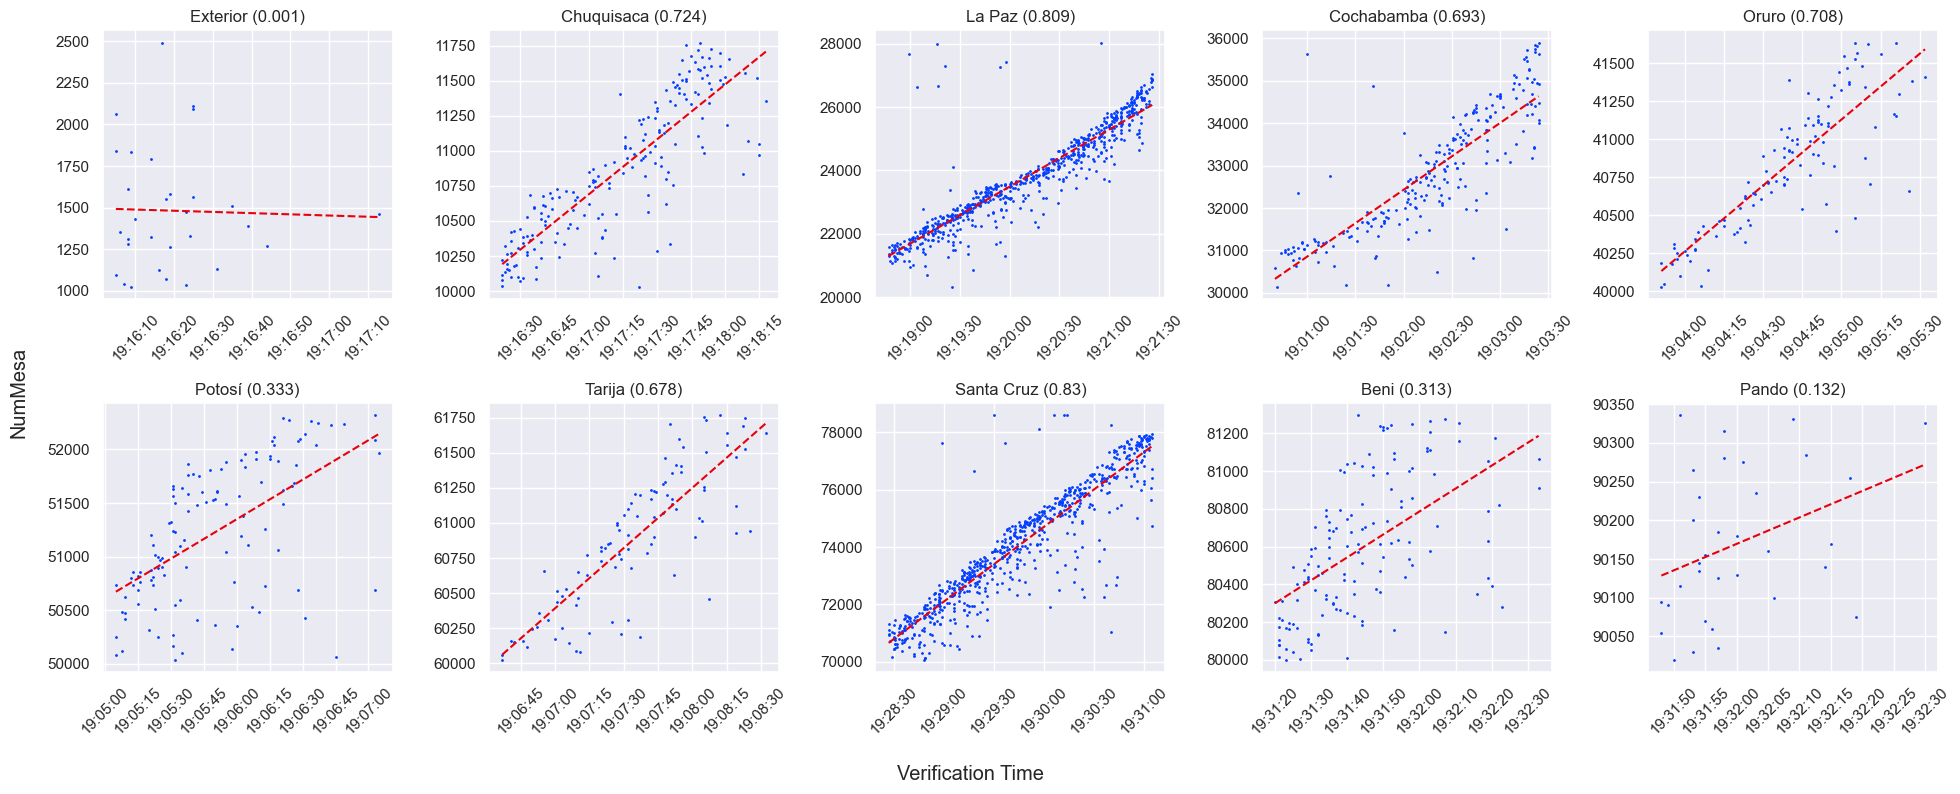

In [19]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)

interval = pd.Timedelta('3min') # roughly the duration of the longest regional verification spike.
for region, ax in zip(['Exterior'] + dep_names, axes.flat):
    old_verifs_reg = old_verifs[old_verifs.Pais != 'Bolivia' if region == 'Exterior' else old_verifs.Dep == region]
    if old_verifs_reg.empty:
        ax.set_title(region)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        continue
    
    # find region's peak period for the verification of old actas.
    old_verifs_peak = pd.Series(1, index=old_verifs_reg.evt_time).rolling(interval).count().idxmax()
    old_verifs_slice = old_verifs_reg[old_verifs_reg.evt_time.between(old_verifs_peak - interval, old_verifs_peak)]
    old_verifs_slice = old_verifs_slice[old_verifs_slice.evt_time.between(*old_verifs_slice.evt_time.quantile([0.05, 0.95]))] # trim a bit.
    ax.scatter(old_verifs_slice.evt_time, old_verifs_slice.NumMesa, s=1)
    
    # show linear trend.
    from sklearn.linear_model import LinearRegression
    evt_times = old_verifs_slice.evt_time.values.astype(np.int64).reshape(-1, 1) # convert to numeric
    y_pred = LinearRegression().fit(evt_times, old_verifs_slice.NumMesa).predict(evt_times)
    ax.plot(old_verifs_slice.evt_time, y_pred, 'r--')
    
    # r^2
    from sklearn.metrics import r2_score
    ax.set_title(f"{region} ({round(r2_score(old_verifs_slice.NumMesa, y_pred), 3)})")
    
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%H:%M:%S'))
    for _ in ax.get_xticklabels(): _.set_rotation(45)

fig.supxlabel('Verification Time')
fig.supylabel('NumMesa\n')
fig.tight_layout()

The trend isn't super clean, but I also wouldn't expect it to be, since these acta columns would've only been *served out* in order. They wouldn't have come back in that same order. I tend to discount the importance of the weaker fits that you see in the smaller regions, since a small region's whole range of station identifiers could've been served out almost instantly, so you wouldn't expect to see too much of a trend in when they came back. Larger regions like La Paz and Santa Cruz make the trend clearer because they're big enough that verifiers would've needed some time to work through them all. Who knows about overseas vote, though. Maybe it's different in some way.

### Case-by-Case Review of Actas Unresolved by Cómputo Image Transmission Timestamps ###

A review of the cases during Period #2 that still have long wait times even when you take into account Cómputo image transmission timestamps.

In [20]:
spike2 = img_times[(img_times.verif >= '2019-10-20 19:32') & (img_times.verif < '2019-10-21')]
spike2.drop(columns=['is_comp_multi_send']) \
    .rename(columns={'tx_first': 'actalog_tx', 'verif': 'actalog_verif'}) \
    .pipe(lambda x: x[x.new_time_to_verif >= pd.Timedelta('2min')]) \
    .sort_values('new_time_to_verif', ascending=False)
# ROW1: #1692 seems like it was resent (and slowly approved?) then verified?
# ROW2: #1748 is weird, tho? no resend, just sat for 16 minutes. (see photo. carbon copy. hard to read.)
# ROW3: #1155 sat for 6min, but the photo is good. hmm. not sure.
# ROW4: #1749 sat for 5min, photo seems reasonable. again, not sure.
# ROW5: #1171 sat for 5min, photo seems perfect. again, not sure.
# ROW6: #1555 sat for 3min, photo seems reasonable. again, not sure.

,NumMesa,actalog_tx,comp_img_first,comp_img_last,pool_earliest,pool_latest,served,actalog_verif,actalog_time_to_verif,new_time_to_verif
col_id,,,,,,,,,,
691,1692,2019-10-20 19:20:02,2019-10-20 19:24:00,2019-10-20 19:42:00,2019-10-20 19:23:00,2019-10-20 19:24:00,2019-10-20 19:45:45,2019-10-20 19:46:15,0 days 00:26:13,0 days 00:22:45
747,1748,2019-10-20 19:32:55,2019-10-20 19:33:00,2019-10-20 19:33:00,2019-10-20 19:32:55,2019-10-20 19:33:00,2019-10-20 19:48:53,2019-10-20 19:49:23,0 days 00:16:28,0 days 00:16:25.500000
154,1155,2019-10-20 19:46:43,2019-10-20 19:48:00,2019-10-20 19:48:00,2019-10-20 19:47:00,2019-10-20 19:48:00,2019-10-20 19:53:05,2019-10-20 19:53:35,0 days 00:06:52,0 days 00:06:05
748,1749,2019-10-20 19:35:09,2019-10-20 19:39:00,2019-10-20 19:39:00,2019-10-20 19:38:00,2019-10-20 19:39:00,2019-10-20 19:43:46,2019-10-20 19:44:16,0 days 00:09:07,0 days 00:05:46
170,1171,2019-10-20 19:43:47,2019-10-20 19:45:00,2019-10-20 19:45:00,2019-10-20 19:44:00,2019-10-20 19:45:00,2019-10-20 19:49:19,2019-10-20 19:49:49,0 days 00:06:02,0 days 00:05:19
554,1555,2019-10-20 19:40:58,2019-10-20 19:42:00,2019-10-20 19:42:00,2019-10-20 19:41:00,2019-10-20 19:42:00,2019-10-20 19:44:21,2019-10-20 19:44:51,0 days 00:03:53,0 days 00:03:21


Not sure!

### Observation: The TREP Had Another Review Process That's Not Publicly Documented ###

In a pre-election workshop, the director of the SERECI <a href="https://youtu.be/zwEyZ6hIzzY?t=104">mentioned</a> a "call center" which provided general assistance to transmission operators and was responsible for phoning those operators who hadn't sent a photo or had sent an "invalid" one and telling them to send a new photo. He didn't describe the process that marked some photos as "invalid", but a private SERECI report says SERECI Nacional only had 359 TREP workers, nearly all of which would've been verifiers, so they must've depended on the verifiers to signal which acta columns were bad. These verifiers must have done this as part of their normal verification work, and, looking at the web interface used for verifications, the most obvious candidate for how it was done is with the reject button ('x'). Also, in their report, the OAS mentions a process that allowed users—administrators, I assume—to delete blurry acta photos so they could be resent (OAS, p44-45). This sounds like the call center the SERECI director mentioned, and I think it amounts to a review process for actas rejected by verification operators. Some unresolved cases might be actas that were erroneously marked for this review then, after a few minutes, were reintroduced into the TREP's pool of verifiable actas.

<figure>
    <center>
        <img src="./data/imgs/post-imgs/13-sereci-manpower.jpg"/>
        <figcaption style="font-size: 75%">Personnel stats from non-public SERECI report.</figcaption>
    </center>
</figure>

### Observation: The TREP Seems to Have Maintained a Reservoir of Bad, Unprocessed Actas ###

On October 21st at 14:38, the basic (read: non-approval) verification process resumed after a long break. As the process reached its conclusion, the rate of verification failures, already quite elevated, went even higher. This doesn't make sense, though, because VerificaProxima picked columns at random and no new data was entering the system, so there shouldn't have been a trend of increasing failures. Eventually, the TREP ended with the final nine verification attempts all failing one after another—improbable considering 94% of all verification attempts in the election were successful. Of these nine columns, five had an illegible acta image that led a verifier to submit a no-vote transcription, two had clerical errors that resulted in more votes than registered voters, one misclassified non-voters as blank votes due to juror error, and one had a photo of the wrong acta. In other words, bad columns. But nine in a row, and right at the end? Can't be random. There must've been a reservoir of bad columns that was being dumped back into the verification process.

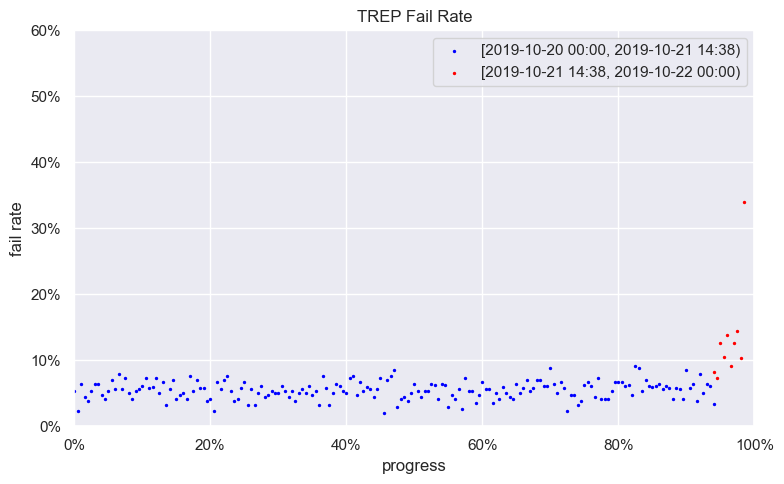

In [21]:
# a little (unsaved) graph to illustrate point about how failures increase substantially at end of trep on oct21
bin_width = 0.005 # half a percent. binning by progress to avoid small sample issues with some of the late time-based bins.
trepv = trep[trep.tx_verif == 'verif'].drop_duplicates(subset='col_id', keep='first')
trepv['progress'] = np.arange(1, len(trepv) + 1) / len(computo)
trepv['progress_bin'] = trepv.progress // bin_width * bin_width

def get_fail_rate(df, start='2019-10-20', end='2019-10-25'):
    verifs_binned = df \
        [df.evt_time.between(start, end, inclusive='left')] \
        .groupby(['progress_bin', 'evt_type']) \
        .size().unstack(level=1).fillna(0)
    return verifs_binned.verif_fail / (verifs_binned.verif + verifs_binned.verif_fail)

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_title('TREP Fail Rate')
ax.set_xlabel('progress')
ax.set_ylabel('fail rate')

early_fail = get_fail_rate(trepv, start='2019-10-20', end='2019-10-21 14:38')
ax.scatter(early_fail.index, early_fail, label='[2019-10-20 00:00, 2019-10-21 14:38)', s=2, color='blue')

late_fail = get_fail_rate(trepv, start='2019-10-21 14:38', end='2019-10-22')
ax.scatter(late_fail.index, late_fail, label='[2019-10-21 14:38, 2019-10-22 00:00)', s=2, color='red')

ax.set_ylim(0, 0.6)
ax.set_xlim(0, 1)
ax.yaxis.set_major_formatter(pct_format)
ax.xaxis.set_major_formatter(pct_format)
ax.legend()

The final nine verification attempts at the end of the TREP, all of which failed:

In [22]:
trep[(trep.tx_verif == 'verif')] \
    .tail(9) \
    .rename(columns={'Emitidos Reales': 'Emitidos'}) \
    ['NumMesa|ElecActa|EstadoActa|Inscritos|Emitidos|CC|FPV|MTS|UCS|MAS|21F|PDC|MNR|PAN-BOL|Validos en Acta|Blancos|Nulos|evt_time'.split('|')]

,NumMesa,ElecActa,EstadoActa,Inscritos,Emitidos,CC,FPV,MTS,UCS,MAS,21F,PDC,MNR,PAN-BOL,Validos en Acta,Blancos,Nulos,evt_time
evt_id,,,,,,,,,,,,,,,,,,
90949,60886,Diputados Uninominales,Esperando aprobación,228,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-10-21 15:04:23
67956,35284,Diputados Uninominales,Esperando aprobación,227,306,14,1,3,106,106,1,0,0,0,207,71,4,2019-10-21 15:05:17
56375,32395,Diputados Uninominales,Esperando aprobación,216,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-10-21 15:06:40
122869,76894,Diputados Uninominales,Esperando aprobación,224,222,20,0,0,1,95,10,7,0,0,135,81,8,2019-10-21 15:06:40
83425,51360,Diputados Uninominales,Esperando aprobación,210,315,3,0,1,0,133,2,0,0,139,139,30,7,2019-10-21 15:08:04
22659,23049,Presidente y Vicepresidente,Esperando aprobación,227,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-10-21 15:08:07
120699,76376,Diputados Uninominales,Esperando aprobación,223,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-10-21 15:09:50
62787,33995,Diputados Uninominales,Esperando aprobación,239,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-10-21 15:11:44
56469,32419,Presidente y Vicepresidente,Esperando aprobación,216,265,5,2,1,58,181,0,3,1,1,194,3,10,2019-10-21 15:13:28


Here's what the tally sheet images looked like:

<center>
    <figure><figcaption>60886/Diputados Uninominales - Illegible Photo</figcaption><img src="./data/imgs/actas/60886.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>35284/Diputados Uninominales - More Votes Than Registered Voters (Clerical Error, Corrected)</figcaption><img src="./data/imgs/actas/35284.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>32395/Diputados Uninominales - Illegible Photo</figcaption><img src="./data/imgs/actas/32395.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>76894/Diputados Uninominales - Mislabeled Votes (Juror Error)</figcaption><img src="./data/imgs/actas/76894.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>51360/Diputados Uninominales - More Votes Than Registered Voters (Clerical Error, Corrected)</figcaption><img src="./data/imgs/actas/51360.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>23049/Presidente y Vicepresidente - Illegible Photo</figcaption><img src="./data/imgs/actas/23049.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>76376/Diputados Uninominales - No TREP Photo Available (Likely Illegible Photo)</figcaption><img src="./data/imgs/actas/76376.jpg" height="90%" width="90%" alt="No Photo"/></figure>
    <figure><figcaption>33995/Diputados Uninominales - Illegible Photo</figcaption><img src="./data/imgs/actas/33995.jpg" height="90%" width="90%"/></figure>
    <figure><figcaption>32419/Presidente y Vicepresidente - Wrong Acta</figcaption><img src="./data/imgs/actas/32419.jpg" height="90%" width="90%"/></figure>
</center>

All of this is to say the ActaLog dataset isn't the final word on what was available. However, even with all the data, it might be impossible to get the pool estimate to zero. On p169 of the BISITE report it says that bo2's ActaImagenError table is empty, so maybe it was just a list of outstanding issues that got deleted as they were resolved. (Also, as an aside, the answer to the TSE's 'change in trend' might be in the bo1 database summarized on p169 in the BISITE report. The auditors said the Acta table was all zeroes, but that's kind of suspicious because the ActaLog table shows that Acta was updated 2863 times. More importantly, the PubResul/Resul tables show the results-generation process ran three times. The contents of the PubResul/Resul tables are what bo1's Tomcat/SIMOBOL server would've shown to users (read: the TSE) when they viewed results on bo1's private website. Are those records all zeroes, too? Perhaps not. Finally, that database's ActaImagenError table has 36 records, and I think most of the database's 1.6 GB size is from photos in the ActaImagenLog table. What's in those tables? Unfortunately, the BISITE auditors didn't touch on any of this, effectively squandering the only real chance of answering these questions. Oh well.)